<a href="https://colab.research.google.com/github/Ilia-Gershen/TYP-project/blob/main/DeepLearningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model:

Version one with 1to1 input and only closing price used as input parameter



## Importing libraries and data from google drive


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

#for Normalization 
from sklearn import preprocessing

In [2]:
from google.colab import drive #connecting google drive with Database of the project
drive.mount('/content/drive')

# Importing the csv made in data preprocessing stage
ETH = pd.read_csv("/content/drive/MyDrive/Database/ETH-preprocessed.csv")
ETH.head()

Mounted at /content/drive


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1.181530e+09
1,1,2017-11-20,354.093994,372.136993,353.289001,366.730011,366.730011,8.070270e+08
2,2,2017-11-21,367.442993,372.470001,350.692993,360.401001,360.401001,9.499120e+08
3,3,2017-11-22,360.312012,381.420013,360.147003,380.652008,380.652008,8.008190e+08
4,4,2017-11-23,381.438995,425.548004,376.088013,410.165985,410.165985,1.845680e+09


## Data Processing

In [ ]:
def Dataset(Data, Date): #function for creation of traning and testing datasets for the models

  #Data for Training 
  #From 2018 to 2022
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  for i in range(0, len(Train_Data), 7): #putting in close values data in form of weeks aka 7 days
    try:
      TrainingData.append(Train_Data[i : i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
    TrainingData.pop(-1)

  TrainingDataX = TrainingData[0 : -1] # taking all but last element
  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 7, 1)) #split into groups of 7 

  
  TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) # split into groups of 7 and keep the order

  # So in the end x is all previous weeks and y is all next weeks 

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  for i in range(0, len(Val_Data), 7):
    try:
      ValData.append(Val_Data[i : i + 7])
    except:
      pass

  if len(ValData[-1]) < 7:
    ValData.pop(-1)

  ValDataX = ValData[0 : -1]
  ValDataX = np.array(ValDataX)
  ValDataX = ValDataX.reshape((-1, 7, 1))

  ValDataY = ValData[1 : len(ValData)]
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

  #Data for Testing 
  #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 7):
    try:
      TestData.append(Test_Data[i : i+7])
    except:
      pass

  if len(TestData[-1]) < 7:
    TestData.pop(-1)

  TestDataX = TestData[0 : -1]
  TestDataX = np.array(TestDataX)
  TestDataX = TestDataX.reshape((-1, 7, 1))

  TestDataY = TestData[1 : len(TestData)]
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))
 
  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, '2021-11-20')
print(ETH_Train_X)
print(np.shape(ETH_Train_X))
print(np.shape(ETH_Train_Y))

[[[ 354.385986]
  [ 366.730011]
  [ 360.401001]
  ...
  [ 410.165985]
  [ 474.911011]
  [ 466.276001]]

 [[ 471.329987]
  [ 480.355011]
  [ 472.902008]
  ...
  [ 447.114014]
  [ 466.540009]
  [ 463.449005]]

 [[ 465.852997]
  [ 470.20401 ]
  [ 463.281006]
  ...
  [ 434.40799 ]
  [ 456.031006]
  [ 473.502014]]

 ...

 [[4294.453613]
  [4445.10498 ]
  [4631.479004]
  ...
  [4511.302246]
  [4220.706055]
  [4119.587402]]

 [[4198.322754]
  [4358.737305]
  [4315.061523]
  ...
  [4119.815918]
  [3908.496094]
  [4084.452393]]

 [[4134.453125]
  [3784.226807]
  [3745.44043 ]
  ...
  [3962.469727]
  [3879.486572]
  [3960.860107]]]
(213, 7, 1)
(213, 7, 1)


## Model creation and testing

### LSTM - GRU model 1 to 1 (one week in one out)


In [ ]:
def Model():

  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.LSTM(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [ ]:
model = Model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 7, 200)            161600    
                                                                 
 gru_13 (GRU)                (None, 200)               241200    
                                                                 
 dense_13 (Dense)            (None, 100)               20100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 7)                 357       
                                                                 
Total params: 428,307
Trainable params: 428,307
Non-trainable params: 0
_________________________________________________________________


#### Learning Rate

In [ ]:
def scheduler(epoch):
  if epoch <= 100:
    lrate = epoch * (10 ** -6)
  else:
    lrate = 0.00001

  return lrate

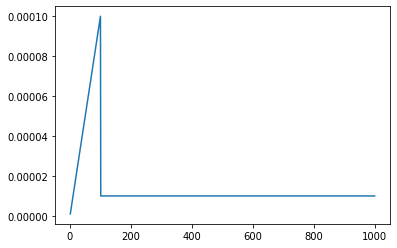

In [ ]:
epoch = [i for i in range(1, 1001)]
lrate = [scheduler(i) for i in range(1, 1001)]
plt.plot(epoch, lrate)

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#### Split Data into Training and Testing sets


*   Training Period: 2017-11-19 to 2022-01-01
* Validation Period: 2022-01-01 to 2022-06-01
*   Testing Period: 2022-06-02 to 2022-11-19



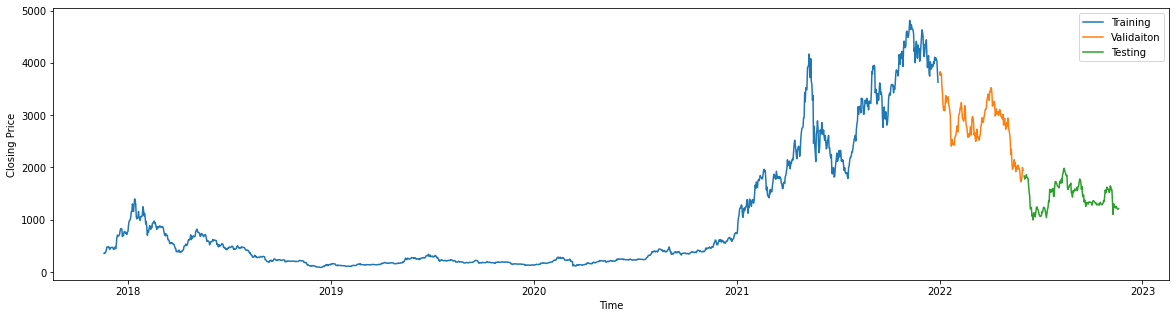

In [ ]:
#Swap date into right format
ETH["Date"] = pd.to_datetime(ETH["Date"])

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, '2021-11-20')
#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

#### Model Fitting

In [ ]:
ETH_Model = Model()

In [ ]:
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

Epoch 1/200
7/7 [==============================] - 4s 129ms/step - loss: 2105785.0000 - root_mean_squared_error: 1451.1322 - val_loss: 7625306.5000 - val_root_mean_squared_error: 2761.3958 - lr: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 50ms/step - loss: 2102303.0000 - root_mean_squared_error: 1449.9321 - val_loss: 7623221.0000 - val_root_mean_squared_error: 2761.0181 - lr: 1.0000e-06
Epoch 3/200
7/7 [==============================] - 0s 48ms/step - loss: 2100093.5000 - root_mean_squared_error: 1449.1699 - val_loss: 7617189.5000 - val_root_mean_squared_error: 2759.9258 - lr: 2.0000e-06
Epoch 4/200
7/7 [==============================] - 0s 49ms/step - loss: 2097380.7500 - root_mean_squared_error: 1448.2336 - val_loss: 7605867.0000 - val_root_mean_squared_error: 2757.8740 - lr: 3.0000e-06
Epoch 5/200
7/7 [==============================] - 0s 47ms/step - loss: 2091511.1250 - root_mean_squared_error: 1446.2058 - val_loss: 7591065.0000 - val_root_mean_squared_error: 2

In [ ]:
historyDict = ETH_hist.history

loss = historyDict["loss"]
root_mean_squared_error = historyDict["root_mean_squared_error"]
valLoss = historyDict["val_loss"]
val_root_mean_squared_error = historyDict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

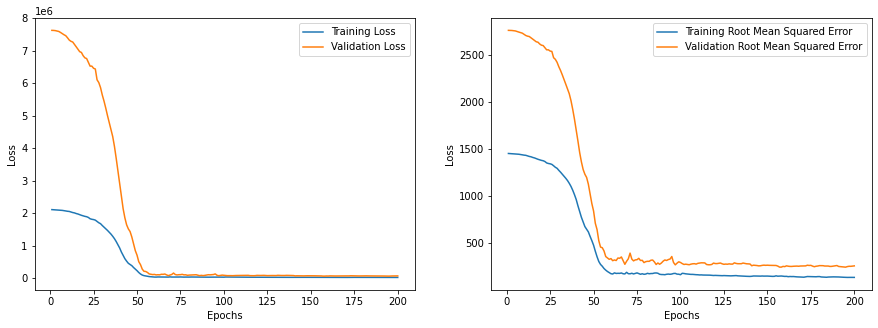

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, valLoss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

#### Predicting the closing price for ETH for a week

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

1/1 [==============================] - 0s 375ms/step


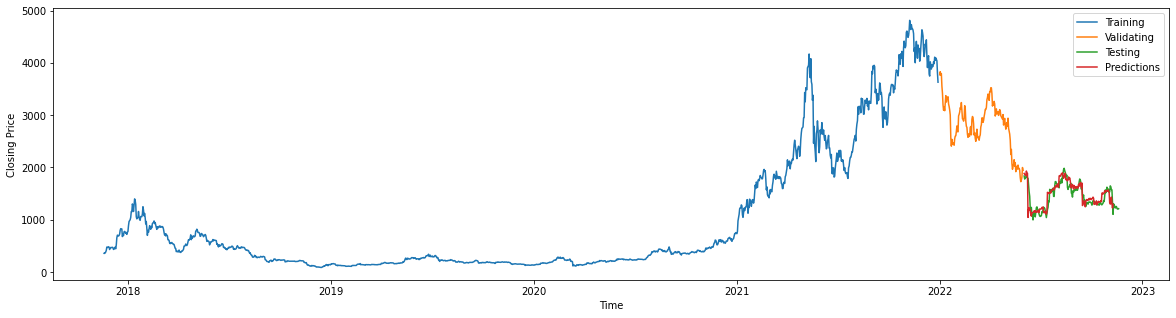

In [ ]:
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validating')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

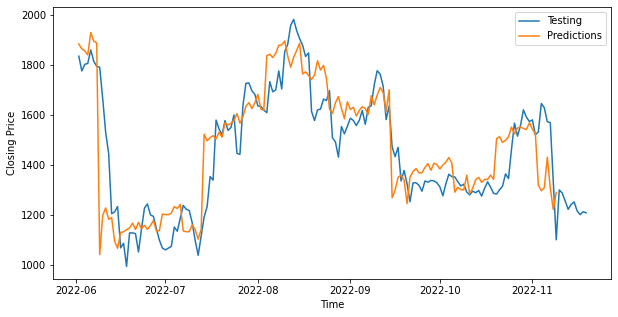

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction))
mape = np.mean(np.abs(ETH_Test_Y.reshape(-1,7) - ETH_prediction )/np.abs(ETH_Test_Y.reshape(-1,7))) * 100
print(f'RMSE: {rmse}') #lower is better
print(f'MAPE: {mape}') #mape should be as close to 0 as possible, but mape within 10% is ok

RMSE: 171.8512539187178
MAPE: 8.1832967547677


# New model
With 1to1 format of input, but closing price and volume of trading are used as input

In [3]:
def Dataset(Data, Date): #function for creation of traning and testing datasets for the models

  #Data for Training 
  #From 2018 to 2022
  Train_DataY = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  #0+
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()
  print(len(Train_Data))
  #1502+
  Train_Data_Val = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()
  print(len(Train_Data_Val))
  #1652+
  Train_Data_Test = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  print(len(Train_Data_Test))
  Train_Data = np.append(Train_Data,  Train_Data_Val)
  print(len(Train_Data))
  print(np.shape(Train_Data))
  Train_Data = np.append(Train_Data,  Train_Data_Test)
  print(len(Train_Data))
  print(np.shape(Train_Data))

  #Normalize
  Train_Data = Train_Data.reshape(1, -1)
  Train_Data = preprocessing.normalize(Train_Data)

  print(len(Train_Data))
  print(np.shape(Train_Data))

  #0+
  Volume_Data = Data['Volume'][Data['Date'] < '2021-12-30'].to_numpy()
  print(len(Volume_Data))
  #1502+
  Volume_Data_Val = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()
  print(len(Volume_Data_Val))
  #1652+
  Volume_Data_Test = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()
  print(len(Volume_Data_Test))
  Volume_Data = np.append(Volume_Data,  Volume_Data_Val)
  print(len(Volume_Data))
  print(np.shape(Volume_Data))
  Volume_Data = np.append(Volume_Data,  Volume_Data_Test)
  print(len(Volume_Data))
  print(np.shape(Volume_Data))

  #Normalize
  Volume_Data = Volume_Data.reshape(1, -1)
  Volume_Data = preprocessing.normalize(Volume_Data)

  print(len(Volume_Data))
  print(np.shape(Volume_Data))

  #The training output of the model in TrainingDataY
  for i in range(0, len(Train_DataY), 7): #putting in close values data in form of weeks aka 7 days
    try:
      TrainingData.append(Train_DataY[i : i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
    TrainingData.pop(-1)

  TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) #split into groups of 7

  #The training input for the model in TrainingDataX
  TrainingDataXWV = np.zeros((213, 7, 2))

  counter = 0
  for i in range(213):
    for l in range(7): 
      TrainingDataXWV[i,l,0] = Train_Data[0,counter]
      TrainingDataXWV[i,l,1] = Volume_Data[0,counter]
      counter += 1

  TrainingDataX = TrainingDataXWV

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  #Volume_Data = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date

  for i in range(0, len(Val_Data), 7): #putting in close values data in form of weeks aka 7 days
    try:
      ValData.append(Val_Data[i : i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(ValData[-1]) < 7: #If last week is less then 7 days we remove last week
    ValData.pop(-1)

  ValDataY = ValData[1 : len(ValData)]
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  ValDataXWV = np.zeros((20, 7, 2))

  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataXWV[i,l,0] = Train_Data[0,1502+counter]
      ValDataXWV[i,l,1] = Volume_Data[0,1502+counter]
      counter += 1

  ValDataX = ValDataXWV
  print(ValDataX)

  #Data for Testing 
  #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  #Volume_Data = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()

  for i in range(0, len(Test_Data), 7): #putting in close values data in form of weeks aka 7 days
    try:
      TestData.append(Test_Data[i : i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(TestData[-1]) < 7: #If last week is less then 7 days we remove last week
    TestData.pop(-1)

  TestDataY = TestData[1 : len(TestData)]
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  TestDataXWV = np.zeros((23, 7, 2))
  
  counter = 0
  for i in range(23):
    for l in range(7):
      #TrainingDataX[i, l].append(Volume_Data[counter]) 
      TestDataXWV[i,l,0] = Train_Data[0,1653+counter]
      TestDataXWV[i,l,1] = Volume_Data[0,1653+counter]
      counter += 1

  TestDataX = TestDataXWV
 
  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, '2021-11-20')

1502
151
171
1653
(1653,)
1824
(1824,)
1
(1, 1824)
1502
151
171
1653
(1653,)
1824
(1824,)
1
(1, 1824)
[[[0.05355683 0.0134462 ]
  [0.05440739 0.013591  ]
  [0.05343868 0.01661593]
  [0.05390291 0.01929817]
  [0.05044105 0.02484161]
  [0.048566   0.03341374]
  [0.04536657 0.03368935]]

 [[0.04392827 0.02205834]
  [0.0448628  0.01696515]
  [0.04380218 0.02686951]
  [0.04600449 0.02092186]
  [0.04791034 0.02291815]
  [0.04614908 0.02103605]
  [0.04702585 0.01865452]]

 [[0.04731751 0.01323137]
  [0.04760721 0.01307449]
  [0.04563785 0.01697839]
  [0.04495193 0.01791345]
  [0.04398301 0.01813802]
  [0.04263751 0.01464243]
  [0.03634104 0.03685569]]

 [[0.03417088 0.03764434]
  [0.0360158  0.02266868]
  [0.03467057 0.03881496]
  [0.03489196 0.0222537 ]
  [0.03506379 0.02919967]
  [0.03442406 0.02218046]
  [0.03618704 0.02017197]]

 [[0.0368973  0.01536608]
  [0.03698796 0.013068  ]
  [0.03819291 0.01895062]
  [0.03966816 0.01814822]
  [0.03811584 0.0190855 ]
  [0.03806339 0.01754395]
  [0.0

In [4]:
def Model():
#The input shape is going to be 14 total 7 close and 7 volume
  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.LSTM(200, input_shape = (7,2), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [5]:
model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 200)            162400    
                                                                 
 gru (GRU)                   (None, 200)               241200    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 429,107
Trainable params: 429,107
Non-trainable params: 0
_________________________________________________________________


In [6]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00009
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

1502
151
171
1653
(1653,)
1824
(1824,)
1
(1, 1824)
1502
151
171
1653
(1653,)
1824
(1824,)
1
(1, 1824)
[[[0.05355683 0.0134462 ]
  [0.05440739 0.013591  ]
  [0.05343868 0.01661593]
  [0.05390291 0.01929817]
  [0.05044105 0.02484161]
  [0.048566   0.03341374]
  [0.04536657 0.03368935]]

 [[0.04392827 0.02205834]
  [0.0448628  0.01696515]
  [0.04380218 0.02686951]
  [0.04600449 0.02092186]
  [0.04791034 0.02291815]
  [0.04614908 0.02103605]
  [0.04702585 0.01865452]]

 [[0.04731751 0.01323137]
  [0.04760721 0.01307449]
  [0.04563785 0.01697839]
  [0.04495193 0.01791345]
  [0.04398301 0.01813802]
  [0.04263751 0.01464243]
  [0.03634104 0.03685569]]

 [[0.03417088 0.03764434]
  [0.0360158  0.02266868]
  [0.03467057 0.03881496]
  [0.03489196 0.0222537 ]
  [0.03506379 0.02919967]
  [0.03442406 0.02218046]
  [0.03618704 0.02017197]]

 [[0.0368973  0.01536608]
  [0.03698796 0.013068  ]
  [0.03819291 0.01895062]
  [0.03966816 0.01814822]
  [0.03811584 0.0190855 ]
  [0.03806339 0.01754395]
  [0.0

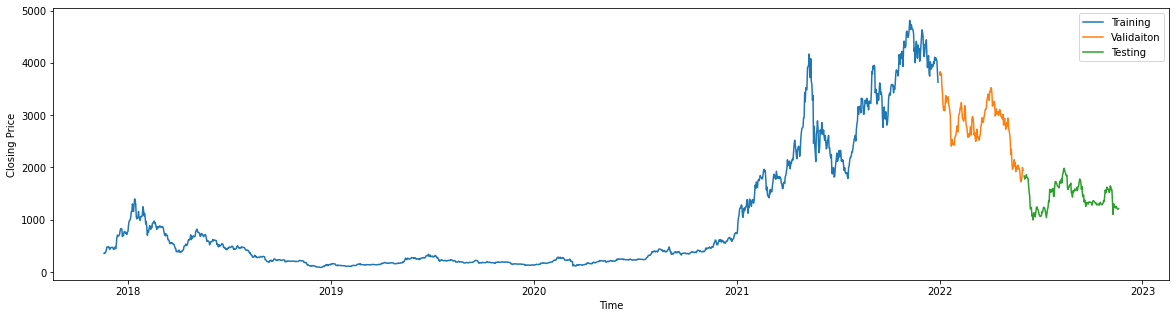

In [7]:
#Swap date into right format
ETH["Date"] = pd.to_datetime(ETH["Date"])

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, '2021-11-20')
#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')


In [8]:
ETH_Model = Model()

ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

Epoch 1/200
7/7 [==============================] - 4s 128ms/step - loss: 2212388.0000 - root_mean_squared_error: 1487.4098 - val_loss: 8007306.5000 - val_root_mean_squared_error: 2829.7183 - lr: 9.0000e-05
Epoch 2/200
7/7 [==============================] - 0s 49ms/step - loss: 2212375.2500 - root_mean_squared_error: 1487.4054 - val_loss: 8007261.5000 - val_root_mean_squared_error: 2829.7104 - lr: 9.0000e-05
Epoch 3/200
7/7 [==============================] - 0s 57ms/step - loss: 2212358.5000 - root_mean_squared_error: 1487.3999 - val_loss: 8007207.0000 - val_root_mean_squared_error: 2829.7007 - lr: 9.0000e-05
Epoch 4/200
7/7 [==============================] - 0s 52ms/step - loss: 2212339.0000 - root_mean_squared_error: 1487.3933 - val_loss: 8007134.5000 - val_root_mean_squared_error: 2829.6880 - lr: 9.0000e-05
Epoch 5/200
7/7 [==============================] - 0s 51ms/step - loss: 2212311.5000 - root_mean_squared_error: 1487.3842 - val_loss: 8007041.5000 - val_root_mean_squared_error: 2

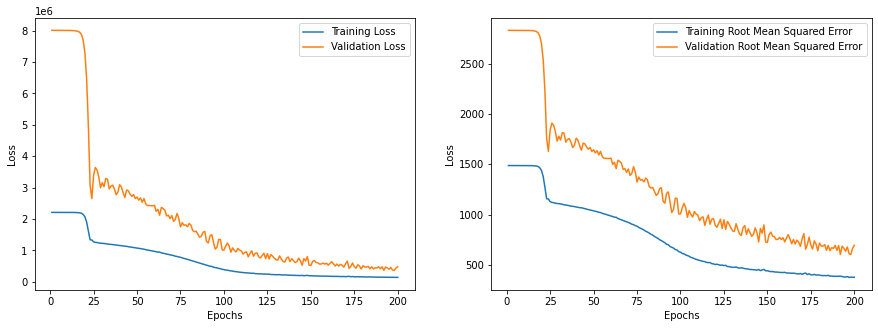

In [9]:
historyDict = ETH_hist.history

loss = historyDict["loss"]
root_mean_squared_error = historyDict["root_mean_squared_error"]
valLoss = historyDict["val_loss"]
val_root_mean_squared_error = historyDict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, valLoss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

1/1 [==============================] - 0s 365ms/step
[[[0.02605814 0.0234713 ]
  [0.02521889 0.02046324]
  [0.02559582 0.01193568]
  [0.0256469  0.01217284]
  [0.0264153  0.02271955]
  [0.02577254 0.03303727]
  [0.02548164 0.02481429]]

 [[0.02542841 0.01652282]
  [0.02365558 0.02545147]
  [0.02173223 0.02905825]
  [0.02053248 0.03227392]
  [0.01711375 0.06211701]
  [0.01721433 0.04583917]
  [0.01752041 0.05163261]]

 [[0.01516946 0.02600566]
  [0.01543639 0.02006917]
  [0.01411679 0.0297849 ]
  [0.01602084 0.02997756]
  [0.01602064 0.02715002]
  [0.01598061 0.02150041]
  [0.01493776 0.02064561]]

 [[0.01624432 0.02016046]
  [0.01743003 0.02335647]
  [0.0176659  0.0171677 ]
  [0.01704625 0.0166377 ]
  [0.01695886 0.01718184]
  [0.01626126 0.01928755]
  [0.01561291 0.02116234]]

 [[0.01516333 0.02248887]
  [0.01505632 0.02406879]
  [0.01515216 0.01366545]
  [0.01525522 0.01176966]
  [0.01635332 0.01880297]
  [0.01611865 0.02227536]
  [0.01686357 0.0211448 ]]

 [[0.01758273 0.01957307]
 

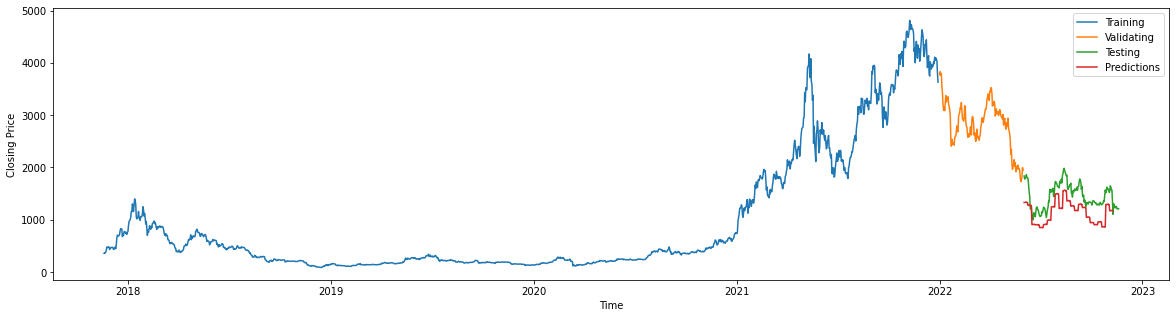

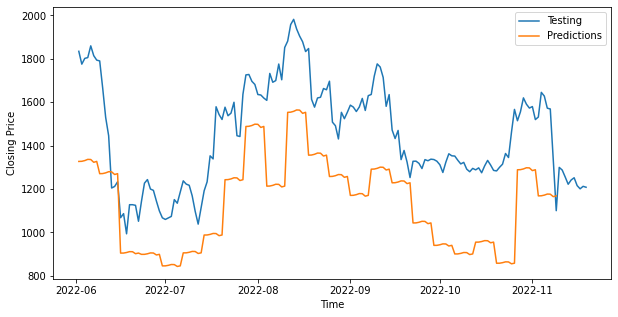

In [10]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

print(ETH_Test_X)
print(ETH_prediction)

plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validating')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [11]:
rmse = math.sqrt(mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction))
mape = np.mean(np.abs(ETH_Test_Y.reshape(-1,7) - ETH_prediction )/np.abs(ETH_Test_Y.reshape(-1,7))) * 100
print(f'RMSE: {rmse}') #lower is better
print(f'MAPE: {mape}')

RMSE: 373.13503387742253
MAPE: 21.91211825187175
